In [1]:
# Core libraries
import numpy as np
from skimage import io, util, morphology, exposure, measure
from scipy.spatial import Voronoi, Delaunay
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# Specific utils
from imageUtils import draw_labels_on_image, colorize_segmentation, normalize_exposure_by_axis
from trimesh import Trimesh, geometry
from trimesh.curvature import discrete_gaussian_curvature_measure, \
    discrete_mean_curvature_measure, sphere_ball_intersection
import pyvista as pv

# General utils
from tqdm import tqdm
from os import path,makedirs
import pickle as pkl

dt = 12 #hrs
dx = 0.25
dz = 1
Z_SHIFT = 10
KAPPA = 5 # microns


In [2]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}

dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
figure_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Morphology differences'

all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))
divisions_12h = pd.read_pickle(path.join(dataset_dir,f'divisions_12h.pkl'))
divisions_24h = pd.read_pickle(path.join(dataset_dir,f'divisions_24h.pkl'))
divisions_36h = pd.read_pickle(path.join(dataset_dir,f'divisions_36h.pkl'))
divisions_48h = pd.read_pickle(path.join(dataset_dir,f'divisions_48h.pkl'))
divisions_56h = pd.read_pickle(path.join(dataset_dir,f'divisions_56h.pkl'))
divisions_60h = pd.read_pickle(path.join(dataset_dir,f'divisions_60h.pkl'))
divisions_72h = pd.read_pickle(path.join(dataset_dir,f'divisions_72h.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))

# Load segmentations
tracked_cyto = io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif'))

NameError: name 'dirname' is not defined

In [33]:
import stackview
stackview.slice(micromask)

In [15]:
from measurements import estimate_sh_coefficients

micro_sh_coeffients = []
for region,dirname in dirnames.items():

    tracked_cyto = io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif'))
    adjacent_tracks = [np.load(path.join(dirname,f'Mastodon/basal_connectivity_3d/adjacenct_trackIDs_t{t}.npy'),
                               allow_pickle=True).item() for t in range(15)]

    for frame in tqdm(range(15)):
    
        this_frame = tracked_cyto[frame,...]
        coeffs = {}
        
        for trackID in list(adjacent_tracks[frame].keys()):
            
            if all_df.loc[frame,region+'_'+str(trackID)]['Frac of neighbors are border','Meta'] == 0:
                adjIDs = adjacent_tracks[frame][trackID]
                micromask = (this_frame == trackID)
                for ID in adjIDs:
                    micromask = micromask | (this_frame == ID)
                if micromask.sum() > 0:
                    coeffs[trackID] = estimate_sh_coefficients(micromask.astype(int),
                                                               spacing=[dz,dx,dx],lmax=10)
        
        coeffs = pd.concat(coeffs).droplevel(axis=0,level=1)
        coeffs['TrackID'] = [region + '_' + str(ID) for ID in coeffs.index]
        coeffs['Frame'] = frame
        micro_sh_coeffients.append(coeffs)
    
micro_sh_coeffients = pd.concat(micro_sh_coeffients,ignore_index=True)
micro_sh_coeffients = micro_sh_coeffients.set_index(['Frame','TrackID'])
micro_sh_coeffients.to_csv('/Users/xies/Desktop/microshcoeffs.csv')

  0%|                                                       | 0/15 [00:00<?, ?it/s]/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/aicsshparam/shparam.py:134: UserWarning: Mesh centroid seems to fall outside the object. This indicates        the mesh may not be a manifold suitable for spherical harmonics        parameterization.
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/aicsshparam/shparam.py:134: UserWarning: Mesh centroid seems to fall outside the object. This indicates        the mesh may not be a manifold suitable for spherical harmonics        parameterization.
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/aicsshparam/shparam.py:134: UserWarning: Mesh centroid seems to fall outside the object. This indicates        the mesh may not be a manifold suitable for spherical harmonics        parameterization.
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/aicsshparam/shparam.py:134: UserWa

In [101]:
micro_sh_coeffients = pd.read_csv('/Users/xies/Desktop/microshcoeffs.csv',index_col=[0,1])
micro_sh_coeffients = micro_sh_coeffients.drop(columns='shcoeffs_surface_area')

PC0       PC1       PC2       PC3       PC4       PC5  \
Frame TrackID                                                               
0     R1_1056  0.000353 -2.582023 -1.835189 -0.849241 -0.297262  2.527532   
      R1_240   2.199605  4.825641  3.305847 -0.841990 -0.913395 -0.062933   
      R1_1051  0.849340  0.423557  1.168883  0.885188 -1.385569  0.202108   
      R1_672  -3.033111  4.071931  1.749188  1.356662 -0.093318  0.409920   
      R1_521   2.921252 -3.061076 -1.241046 -2.642515 -2.331754 -0.683608   
...                 ...       ...       ...       ...       ...       ...   
14    R2_827  -0.824631 -0.582114  2.487934  1.809111 -2.381611  0.159214   
      R2_422  -4.383381 -0.703130 -1.647744  1.284174  2.887912 -0.509691   
      R2_24   -2.410011  0.920285  0.655297  3.939038  0.801678 -1.672319   
      R2_918   2.560169 -1.516238 -0.567502 -4.037271 -1.457925  1.136651   
      R2_1062 -4.479918 -6.248938  0.778840  1.534317 -1.509830  1.373793   

                    PC6       PC7       PC8       PC9  ...      PC40  \
Frame TrackID                                          ...             
0     R1_1056 -0.114416 -1.846355  3.736298  0.225154  ...  0.149762   
      R1_240   1.198745 -0.451458 -0.319697  1.955543  ... -0.222483   
      R1_1051 -4.473001  0.599813 -1.146175  1.991668  ...  0.533285   
      R1_672  -0.530609 -0.550820 -1.043294  1.200497  ...  0.761217   
      R1_521  -3.832669  2.781020 -1.691463 -0.464396  ... -0.782595   
...                 ...       ...       ...       ...  ...       ...   
14    R2_827   0.735657 -0.371086  0.303244 -2.046352  ... -0.074879   
      R2_422   1.109053 -2.291689  2.487139  0.291875  ... -0.066079   
      R2_24    0.569105 -2.046661  2.444627 -1.754012  ...  0.377612   
      R2_918   2.439736  0.570723  0.448116  0.274516  ...  0.349782   
      R2_1062 -1.160421 -2.781216  0.056342 -1.058469  ... -0.758180   

                   PC41      PC42      PC43      PC44      PC45      PC46  \
Frame TrackID                                                               
0     R1_1056  0.789072 -0.424473 -0.217541  0.279192  0.611975 -0.176666   
      R1_240   0.850780 -0.530164  0.747680  0.029604  0.794485  0.023354   
      R1_1051  0.138066 -0.098115 -0.497688 -0.067486 -0.268465 -0.594616   
      R1_672  -0.119215  0.587249  0.706260  0.599916  0.430712  0.361170   
      R1_521   0.970224  0.699941  0.079807  0.246310 -0.363965  0.138822   
...                 ...       ...       ...       ...       ...       ...   
14    R2_827  -0.726821  0.253456 -0.567378 -0.685515  0.112918  0.136447   
      R2_422  -0.150504 -0.062561 -0.186122  0.049906 -0.156903 -0.186802   
      R2_24    0.293216  0.372995 -0.020355  0.359679 -0.528632 -0.066256   
      R2_918  -0.554763 -1.449132  0.465225 -0.459023  0.007563  0.801001   
      R2_1062 -2.157339 -0.862295  0.331970  0.476660 -0.832453  0.473979   

                   PC47      PC48      PC49  
Frame TrackID                                
0     R1_1056  0.176030 -1.405934  0.310900  
      R1_240   0.390086 -0.676737 -0.360657  
      R1_1051 -0.203600  0.538066 -0.022256  
      R1_672  -0.717637 -0.348955 -0.579975  
      R1_521   1.113458 -0.425071 -0.602248  
...                 ...       ...       ...  
14    R2_827   0.084588 -0.056930  0.380542  
      R2_422   0.475040  0.059998  0.099637  
      R2_24    0.611310  0.318893 -0.027245  
      R2_918   0.474642 -0.507599  0.095318  
      R2_1062  0.475152 -0.686760  0.693036  

[6499 rows x 50 columns]

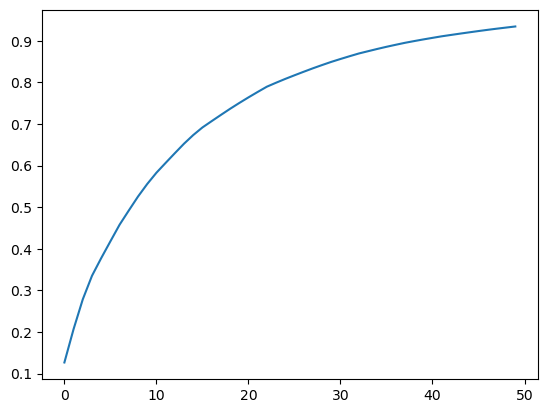

In [102]:
# coeffs = pd.concat(coeffs).droplevel(axis=0,level=1)
# coeffs['TrackID'] = ['R1_' + str(ID) for ID in coeffs.index]

from sklearn import decomposition, preprocessing

pca = decomposition.PCA(n_components = 50)
X_ = micro_sh_coeffients.values
# X_ = preprocessing.StandardScaler().fit_transform(micro_sh_coeffients.values)
X_ = pca.fit_transform(X_)
X_ = pd.DataFrame(X_,index=micro_sh_coeffients.index,columns=[f'PC{i}' for i in range(50)])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
components = pd.DataFrame(pca.components_,index=[f'PC{i}' for i in range(50)],columns=micro_sh_coeffients.columns)
# micro_sh_coeffients.loc[0,'R1_505']
X_

In [34]:
import pyvista as pv
from aicsshparam import shtools

def reconstruct_mesh(coeffs,lmax=5):
    coeffs = coeffs.to_dict()
    # coeffs = {'_'.join(k.split('_')[1:3]):v for k,v in coeffs.items()}
    # Convert to matrix
    mat = np.zeros((2, lmax + 1, lmax + 1), dtype=np.float32)
    for L in range(lmax):
        for M in range(L + 1):
            for cid, C in enumerate(["C", "S"]):
                key = f"shcoeffs_L{L}M{M}{C}"
                if key in coeffs.keys():
                    mat[cid, L, M] = coeffs[key]
                else:
                    mat[cid,L,M] = 0
    
    mesh = shtools.get_even_reconstruction_from_coeffs(mat)
    return mesh
def plot_cells_side_by_side(cells,num_grid=None):
    num_cells = len(cells)
    if num_grid is None:
        num_grid = num_cells
        
    pl = pv.Plotter(shape=(1,num_grid))
    for i in range(num_grid):
        if i >= num_cells:
            continue
        pl.subplot(0,i)
        pl.add_mesh(pv.wrap(cells[i]['cyto']),color='y', opacity=1)
        pl.add_axes()
    pl.link_views()
    pl.view_isometric()
    pv.Line((800, 400, 0), (800, 400, 20))
    pl.show()

def reconstruct_mesh_from_averaged_coeffs_(index,coeffs):
    mean_coeffs = coeffs.loc[index].mean()
    avg_cell = {'cyto':reconstruct_mesh(mean_coeffs)[0]}
    return avg_cell

def get_sorted_cell_indexes(df,feature):
    return df.droplevel(axis=1,level=1).dropna(subset=feature).sort_values(feature).index

In [103]:
## Get top/bottom by feature
# feature = 'nuc_shcoeff_PC3'
feature = 'PC8'

high_cells = X_[feature].argsort()

high = reconstruct_mesh_from_averaged_coeffs_(X_[feature].sort_values().tail(10).index,micro_sh_coeffients)
low = reconstruct_mesh_from_averaged_coeffs_(X_[feature].sort_values().head(10).index,micro_sh_coeffients)

plot_cells_side_by_side([low,high])

Widget(value='<iframe src="http://localhost:63377/index.html?ui=P_0x3151723c0_17&reconnect=auto" class="pyvist…

In [104]:
micro_sh_coeffients.loc[I].index

MultiIndex([( 0, 'R1_1056'),
            ( 0,  'R1_240'),
            ( 0, 'R1_1051'),
            ( 0,  'R1_672'),
            ( 0,  'R1_521'),
            ( 0,  'R1_158'),
            ( 0,  'R1_671'),
            ( 0,  'R1_531'),
            ( 0,  'R1_530'),
            ( 0,   'R1_28'),
            ...
            (14,  'R1_528'),
            (14,  'R1_254'),
            (14,  'R1_704'),
            (14,  'R1_969'),
            (14,  'R1_466'),
            (14,  'R1_331'),
            (14,  'R1_705'),
            (14,  'R1_719'),
            (14,  'R1_294'),
            (14,  'R1_572')],
           names=['Frame', 'TrackID'], length=3263)

In [108]:
mother_diff = {}
I = np.stack(micro_sh_coeffients.index.droplevel(0).str.split('_',expand=True))[:,0] == 'R1'
mother_diff['cyto'] = reconstruct_mesh( micro_sh_coeffients.loc[I].mean())[0]
# micro_sh_coefficients
mother_div = {}
I = np.stack(micro_sh_coeffients.index.droplevel(0).str.split('_',expand=True))[:,0] == 'R2'
mother_div['cyto'] = reconstruct_mesh( micro_sh_coeffients.loc[I].mean())[0]

plot_cells_side_by_side([mother_diff,mother_div])

Widget(value='<iframe src="http://localhost:63377/index.html?ui=P_0x314cdfbf0_19&reconnect=auto" class="pyvist…

In [51]:
_df = divisions
diff = _df[_df['At least one daughter differentiated','Meta'] == True].index
div = _df[_df['At least one daughter differentiated','Meta'] == False].index

diff = pd.DataFrame([X_.loc[idx] for idx in diff if idx in X_.index])
div = pd.DataFrame([X_.loc[idx] for idx in div if idx in X_.index])

(diff.mean() - div.mean()).sort_values()

PC1    -0.508399
PC2    -0.406523
PC14   -0.344105
PC5    -0.284978
PC25   -0.254993
PC12   -0.214580
PC15   -0.194856
PC11   -0.190818
PC22   -0.181981
PC17   -0.163594
PC43   -0.139785
PC6    -0.130712
PC38   -0.117104
PC41   -0.105568
PC37   -0.105139
PC18   -0.090091
PC26   -0.078992
PC45   -0.077062
PC28   -0.073582
PC32   -0.072038
PC36   -0.058752
PC39   -0.056966
PC31   -0.056793
PC29   -0.047629
PC21   -0.044516
PC48   -0.044405
PC7    -0.024343
PC24   -0.020038
PC40   -0.017152
PC30   -0.016921
PC10    0.004988
PC33    0.009167
PC34    0.009281
PC46    0.013469
PC19    0.014381
PC44    0.020656
PC49    0.040587
PC42    0.071461
PC16    0.080015
PC27    0.094681
PC47    0.107428
PC35    0.131550
PC13    0.159711
PC4     0.193396
PC23    0.229858
PC20    0.315208
PC8     0.316366
PC0     0.562602
PC3     0.595914
PC9     0.675233
dtype: float64

In [40]:
mother_diff = {}
mother_diff['cyto'] = reconstruct_mesh(micro_sh_coeffients.loc[diff.index].mean())[0]
mother_div = {}
mother_div['cyto'] = reconstruct_mesh(micro_sh_coeffients.loc[div.index].mean())[0]
# low = reconstruct_mesh_from_averaged_coeffs_(X_[feature].sort_values().head(10).index,micro_sh_coeffients)

plot_cells_side_by_side([mother_diff,mother_div])

Widget(value='<iframe src="http://localhost:63377/index.html?ui=P_0x30d843d70_9&reconnect=auto" class="pyvista…